In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Setup:** Following code must be run only once to clone the code repository.


In [ ]:
import os
os.chdir('/content/drive/My Drive/')
!git clone https://github.com/anura-g/PRBX.git

# Run everytime to move to correct directory and install required packages


In [ ]:
import os
os.chdir('/content/drive/My Drive/pytorch-CycleGAN-and-pix2pix')
!pip install dominate
!pip install visdom

# Run only once to download, extract and prepare the datasets in the required format


In [ ]:
!mkdir data-vischema
!wget -P data-vischema https://www.cs.york.ac.uk/vischema/data/VISCHEMA%20SUN%20folders.zip
!wget -P data-vischema https://www.cs.york.ac.uk/vischema/data/VISCHEMA%20VMS.zip

!sudo apt-get install unzip
!unzip -l "data-vischema/VISCHEMA SUN folders.zip" -d "data-vischema/VISCHEMA SUN folders"
!unzip -l "data-vischema/VISCHEMA VMS.zip" -d "data-vischema/VISCHEMA VMS"

import os
import shutil
import random

path_to_sun_folder = "data-vischema/VISCHEMA SUN folders"
path_to_vms_folder = "data-vischema/VISCHEMA VMS"
path_to_prepared_dataset = "data-vischema/vischema_prepared"

os.makedirs(path_to_prepared_dataset, exist_ok=True)
os.makedirs(os.path.join(path_to_prepared_dataset, 'trainA'), exist_ok=True)
os.makedirs(os.path.join(path_to_prepared_dataset, 'trainB'), exist_ok=True)
os.makedirs(os.path.join(path_to_prepared_dataset, 'testA'), exist_ok=True)
os.makedirs(os.path.join(path_to_prepared_dataset, 'testB'), exist_ok=True)

sun_filepaths = []
vms_filepaths = []

for root, dirs, files in os.walk(path_to_sun_folder):
    sun_filepaths += list(map(lambda x: os.path.join(root, x), files))

for root, dirs, files in os.walk(path_to_vms_folder):
    files = [name for name in files if name.endswith('._S.jpg')]
    vms_filepaths += list(map(lambda x: os.path.join(root, x), files))

random.shuffle(sun_filepaths)

train_paths = sun_filepaths[:700]
test_paths = sun_filepaths[700:]

train_filenames = list(map(os.path.basename, train_paths))
test_filenames = list(map(os.path.basename, test_paths))

for filepath, basename in zip(train_paths, train_filenames):
    shutil.copyfile(filepath, os.path.join(path_to_prepared_dataset, 'trainA', basename))
for filepath, basename in zip(test_paths, test_filenames):
    shutil.copyfile(filepath, os.path.join(path_to_prepared_dataset, 'testA', basename))

for filepath in vms_filepaths:
    basename = os.path.basename(filepath)
    target = basename.replace('._S.jpg', '.jpg')
    if target in train_filenames:
        shutil.copyfile(filepath, os.path.join(path_to_prepared_dataset, 'trainB', target))
    elif target in test_filenames:
        shutil.copyfile(filepath, os.path.join(path_to_prepared_dataset, 'testB', target))

# Run following cell to train the model. 
    dataroot = path to the folder containing dataset prepared by above cell
    name = the experiment name (specifically the model will be stored in "checkpoints/{name}")
    

In [ ]:
!python train.py \
                --dataroot ./data-vischema/vischema_prepared/ \
                --name vischema-train \
                --dataset_mode unaligned \
                --model pix2pix \
                --direction AtoB \
                --serial_batches \

# Run following cell to test the model. 
    dataroot = path to the folder containing images that need to be tested/inferred.
    name = the experiment name (specifically the model will be loaded from "checkpoints/{name}/latest_net_G.pth")
    results_dir = directory for storing output results (specifically results will be stored in {results_dir}/{name}/)

In [ ]:
!python test.py \
                --dataroot ./data-vischema/vischema_prepared/testA/ \
                --direction AtoB \
                --model pix2pix \
                --name vischema-train \
                --dataset_mode single \
                --results_dir ./results/ \
                --num_test 100000

# Following code can be run for getting graphs of the training losses.
Edit the **"path_to_loss_logs"** variable to point to the correct file that needs to be visualized.

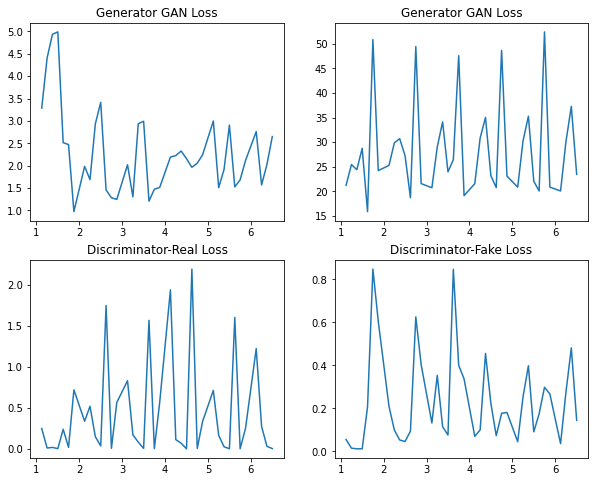

In [ ]:
# Run for graph visualizations. Edit the "path_to_loss_logs" variable to point to the correct 
# file that needs to be visualized.

import string
import matplotlib.pyplot as plt

path_to_loss_logs = "checkpoints/vischema-train/loss_log.txt"

with open(path_to_loss_logs) as f:
    lines = f.readlines()

data = {
    'epoch': [],
    'iters': [],
    'GGAN': [],
    'GL1': [],
    'Dreal': [],
    'Dfake': [],
}
for line in lines:
    if line[0] == '=':
        for key in data.keys():
            data[key] = []
    else:
        tokens = line.strip() \
                        .translate(str.maketrans('', '', string.punctuation.replace('.', ''))) \
                        .split()
        for i, token in enumerate(tokens):
            for key, value in data.items():
                if key in token:
                    value.append(float(tokens[i+1]))

data['iters'] = list(map(lambda x: x/ (max(data['iters']) + min(data['iters'])), data['iters']))

labels = [epoch + iters for epoch, iters in zip(data['epoch'], data['iters'])]

plt.gcf().set_size_inches([10,8])

plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.title("Generator GAN Loss")
plt.plot(labels, data['GGAN'])

plt.subplot(2, 2, 2) # (rows, columns, panel number)
plt.title("Generator GAN Loss")
plt.plot(labels, data['GL1'])

plt.subplot(2, 2, 3) # (rows, columns, panel number)
plt.title("Discriminator-Real Loss")
plt.plot(labels, data['Dreal'])

plt.subplot(2, 2, 4) # (rows, columns, panel number)
plt.title("Discriminator-Fake Loss")
plt.plot(labels, data['Dfake'])

plt.show()